In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# Importing Libraries
This section imports all the necessary libraries that will be used throughout the code, including libraries for data manipulation, visualization, image processing, deep learning, and more.

In [2]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings

2024-06-22 10:13:58.419720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 10:13:58.419852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 10:13:58.547843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


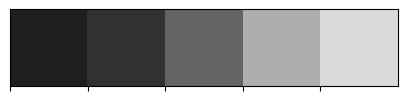

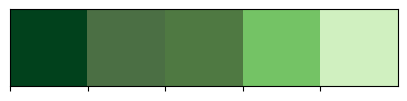

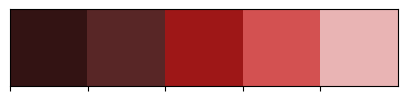

In [3]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)


# Data PreparationIn 
this step, images are loaded from the dataset folders for training and testing. They are resized and stored in arrays.

In [4]:
#Data Preparation
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 130.31it/s]


# Data Augmentation
This part involves creating an ImageDataGenerator for augmenting the training images to improve the model's robustness. It also shuffles the training data.

In [5]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
 
X_train, y_train = shuffle(X_train, y_train, random_state=101)


# Data Splitting
The data is split into training and test sets with a ratio of 90:10.

In [6]:
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101, stratify=y_train)


# Normalization
The pixel values of the images are normalized to the range [0, 1].

In [7]:
#Normalization

X_train = X_train / 255.0
X_test = X_test / 255.0

# Label Encoding
The labels are converted from categorical strings to numerical values and then transformed into one-hot encoding for the model.

In [8]:
#  One Hot Encoding
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)
y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new)


# Using Pre-trained ResNet50
The pre-trained ResNet50 model is loaded with weights trained on ImageNet, excluding the top fully connected layers.

In [9]:
# ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Building the Model
A custom top layer is added to the ResNet50 base model, including global average pooling, batch normalization, dropout, and a dense layer with softmax activation.

In [10]:
#build model
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs=model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,604,100 (90.04 MB)

 Trainable params: 23,546,884 (89.82 MB)

 Non-trainable params: 57,216 (223.50 KB)

# Compiling the Model

In [11]:
# Compiling the Model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), metrics=['accuracy'])


# Callbacks
Several callbacks are defined, including TensorBoard for logging, ModelCheckpoint for saving the best model, and ReduceLROnPlateau for reducing the learning rate when the validation accuracy plateaus.

In [12]:
# Callbacks
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("resnet_bn.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, min_delta=0.001, mode='auto', verbose=1)

# Training the Model
The model is trained using the training data with a validation split of 10%. The defined callbacks are used during training.

In [13]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, verbose=1, batch_size=32, callbacks=[tensorboard, checkpoint, reduce_lr])


Epoch 1/30


I0000 00:00:1719051342.292405      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719051342.385450      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.4821 - loss: 2.0311

W0000 00:00:1719051385.730374      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.31293, saving model to resnet_bn.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 114s 577ms/step - accuracy: 0.4825 - loss: 2.0268 - val_accuracy: 0.3129 - val_loss: 972261.7500 - learning_rate: 0.0030
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5303 - loss: 1.8237
Epoch 2: val_accuracy did not improve from 0.31293
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5303 - loss: 1.8217 - val_accuracy: 0.1156 - val_loss: 3.4881 - learning_rate: 0.0030
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6025 - loss: 1.2577
Epoch 3: val_accuracy did not improve from 0.31293
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.6020 - loss: 1.2594 - val_accuracy: 0.3095 - val_loss: 1.3741 - learning_rate: 0.0030
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5643 - loss: 1.7466
Epoch 4: val_accuracy did not improve from 0.31293

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

# Prediction
Predictions are made on the test data, and the results are converted to class labels.

In [14]:
# Prediction
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1) #خلف
y_test_new = np.argmax(y_test, axis=1)

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

W0000 00:00:1719051656.912355      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 505ms/step


# Evaluation

In [15]:
#Evaluation
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        93
           1       0.93      0.84      0.88        50
           2       0.84      0.84      0.84        94
           3       0.95      0.97      0.96        90

    accuracy                           0.89       327
   macro avg       0.90      0.88      0.89       327
weighted avg       0.89      0.89      0.89       327



#  Widgets for Image Prediction
This part of the code provides an interface for uploading an image and getting a prediction from the trained model using IPython widgets.

In [16]:
# Widgets
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (150, 150))
    img = img.reshape(1, 150, 150, 3)
    p = model.predict(img)
    p = np.argmax(p, axis=1)[0]
    if p == 0:
        p = 'Glioma Tumor'
    elif p == 1:
        print('The model predicts that there is no tumor')
    elif p == 2:
        p = 'Meningioma Tumor'
    else:
        p = 'Pituitary Tumor'
    if p != 1:
        print(f'The Model predicts that it is a {p}')
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
display(widgets.VBox([button, out]))

FileUpload(value={}, description='Upload')

# The model achieved an accuracy of 91% on the test data